In [1]:
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader
from torchvision.transforms import transforms
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
from IPython import display

## Generative adversarial networks

In the last notebook, we saw how we could use probabilistic generative modelling to generate synthetic images. This is cool for generative AI, but also for things like data augmentation, etc. Unfortunately, the VAE quality wasn't great. Generative adversarial networks (GANs) are an alternative. The idea is very simple we will use a generator (decoder) $G(z)$ to take a random sample and generate an image. We will train this decoder to generate realistic images like those in our training set. We will then add a discriminator $D(G(z))$, that tries to classify whether an image was real or fake. 

The generator is going to try to minimise this function:
$$ \mathbb{E}_x [\log (D(x))] + \mathbb{E}_z [\log (1-D(G(z)))] $$
while the discriminator tries to maximise it.

### Activity

Can you try to derive this loss function? Hint, think about the cross entropy loss. If the generator is trying to trick the discriminator, it wants the discriminator to be maximally unsure of whether an image is real or fake. On the other hand, the discriminator wants to be force the generator to generate more realistic images, by becoming very good at telling real images from fake ones. Sounds convoluted? It is. We call this a minimax loss.  

## Building our GAN

Let's implement something a bit like a [DCGAN](https://arxiv.org/pdf/1511.06434.pdf). GANS are notoriously hard to train because of the inherent battle going on in the loss, and this paper has some helpful tips on making them work. Still, you will waste a lot of time on hyperparameter tuning (selecting batch sizes, learning rates, etc.) getting GANs to work - there is even an entire document on [GAN hacks](https://github.com/soumith/ganhacks). For this reason, I dislike them intensely as generative models.

However, this kind of training is very useful to prevent adversarial attacks (remember we looked at some of these earlier in the unit?), to help with data imbalance, and in a number of strategies to make neural networks fairer and less prone to bias.

In [2]:
# Lets start by building a discriminator - this will try to tell if our image is real or fake
class Discriminator(nn.Module):
    
    def __init__(self,channels=3):
        super().__init__()
        
        # We have to use all sorts or architecture tricks to get this to work. Otherwise the GAN will find some sneaky shortcut and 
        # fail to train
        self.encoder = nn.Sequential(nn.Conv2d(channels,32,kernel_size=4,stride=2,padding=1,bias=False),
                                     nn.LeakyReLU(0.2,inplace=True),
                                     nn.Conv2d(32,64,kernel_size=4,stride=2, padding=1, bias=False),
                                     nn.BatchNorm2d(64),
                                     nn.LeakyReLU(0.2,inplace=True),
                                     nn.Conv2d(64,128,kernel_size=4,stride=2,padding=1,bias=False),
                                     nn.BatchNorm2d(128),
                                     nn.LeakyReLU(0.2,inplace=True),
                                     nn.Conv2d(128,256,kernel_size=4,stride=2,padding=1,bias=False),
                                     nn.BatchNorm2d(256),
                                     nn.LeakyReLU(0.2,inplace=True),
                                     nn.Conv2d(256,1,kernel_size=2,stride=1,padding=0,bias=False),
                                     nn.Flatten(),
                                     nn.Sigmoid())
        
        
    def forward(self,x):
        
        return self.encoder(x)

In [3]:
# Next we will build a generator, this will take random noise in and generate an image
class Generator(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        #input latent_dim = 100
        
        self.decoder = nn.Sequential(nn.Unflatten(dim=-1,unflattened_size=(-1,1,1)),
                                     nn.ConvTranspose2d(100,256,kernel_size=4,stride=2,padding=1),
                                     nn.ReLU(),
                                     nn.ConvTranspose2d(256,128,kernel_size=4,stride=2,padding=1),
                                     nn.ReLU(),
                                     nn.ConvTranspose2d(128,64,kernel_size=4,stride=2,padding=1),
                                     nn.ReLU(),
                                     nn.ConvTranspose2d(64,32,kernel_size=4,stride=2,padding=1),
                                     nn.ReLU(),
                                     nn.ConvTranspose2d(32,3,kernel_size=4,stride=2,padding=1),
                                     nn.Tanh())
        
    def forward(self,x):
        
        return self.decoder(x)

In [4]:
# We have to use a specific weight intitialisation to make it work too
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

data = torchvision.datasets.CIFAR10(root='./data/',transform=transform)
train_loader = DataLoader(data,batch_size=64,shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

weights_init(generator)
weights_init(discriminator)

Lets train the model. You'll note I am not implementing the loss abve directly. Instead I'm just going to alternate between tricking my discriminator and correcting it.

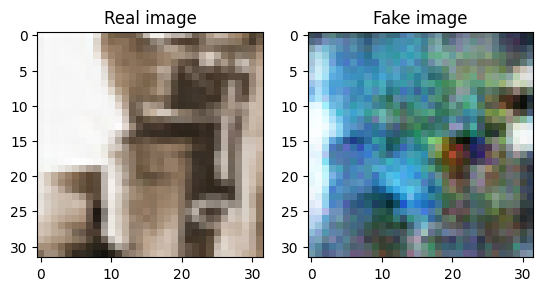

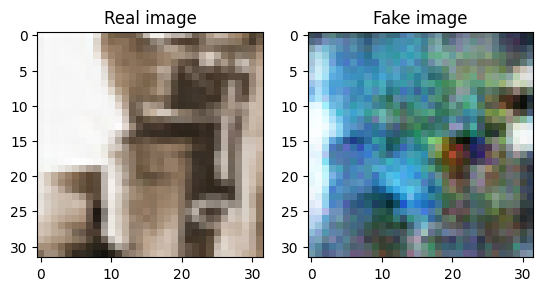

In [7]:
avg_g_loss = None  # exponential moving average
avg_d_loss = None  # exponential moving average
n_epochs = 100

optim_1 = torch.optim.Adam(generator.parameters(),lr=2e-5, betas=(0.5, 0.999))
optim_2 = torch.optim.Adam(discriminator.parameters(),lr=2e-5, betas=(0.5, 0.999)) # Note different learning rates - I don't want my discriminator collapsing first

# This is only going to work if I can manage to find an equilibrium between the losses
    
disc_loss = nn.BCELoss()

for step in range(n_epochs):

    t = tqdm(total=len(train_loader))

    for i,batch in enumerate(train_loader):
        im,_ = batch
        
        im = im.to(device)*2-1
        
        ims_fake = generator(torch.randn(im.shape[0],100,device=device))
        
        # Make some noisy labels - see GAN hacks, ideally this would be just ones and zeros
        real_labels = torch.ones((im.shape[0],1),device=device) - 0.2*torch.rand((im.shape[0],1),device=device)
        fake_labels = torch.zeros((im.shape[0],1),device=device) + 0.2*torch.rand((im.shape[0],1),device=device)
            
        # Generator step
        optim_1.zero_grad()
        fake_pred = discriminator(ims_fake) 
        loss = disc_loss(fake_pred,real_labels) 
        loss.backward() 
        optim_1.step()

    
        
        if avg_g_loss is None:
            avg_g_loss = loss.item()
        else:
            avg_g_loss = 0.95*avg_g_loss + 0.05*loss.item()
        
        #Discriminator  step
        optim_2.zero_grad()
        fake_pred = discriminator(ims_fake.detach()) # Note that we detach the image to prevent gradient flow here 
        real_pred = discriminator(im)
        
        real_loss = disc_loss(real_pred,real_labels)
        fake_loss = disc_loss(fake_pred,fake_labels)
        
        loss = (real_loss + fake_loss)/2.0
        loss.backward()    
        optim_2.step()

        if avg_d_loss is None:
            avg_d_loss = loss.item()
        else:
            avg_d_loss = 0.95*avg_d_loss + 0.05*loss.item()            
    
        # Some visualisation during training.
        t.update(1)
        t.set_description(f"Iter: {step}. Average Generator Loss: {avg_g_loss:.04f} Average Discriminator Loss: {avg_d_loss:.04f}")
    t.reset()
        
    plt.clf()
    plt.subplot(1,2,1)
    plt.imshow(0.5*im[0,:,:,:].transpose(0,2).cpu()+0.5)
    plt.title('Real image')
    plt.subplot(1,2,2)
    plt.imshow(0.5*ims_fake[0,:,:,:].transpose(0,2).detach().cpu()+0.5)
    plt.title('Fake image')
    display.clear_output(wait=True)
    display.display(plt.gcf())

In [8]:
ims_fake.shape

torch.Size([16, 3, 32, 32])

Ok. Let's inspect some samples. Note the [checkerboard-like artifacts](https://distill.pub/2016/deconv-checkerboard/)? These could be avoided if we replace the transposed convolution and striding with an upsampling (bi-linear interpolation) step and conv operation instead.

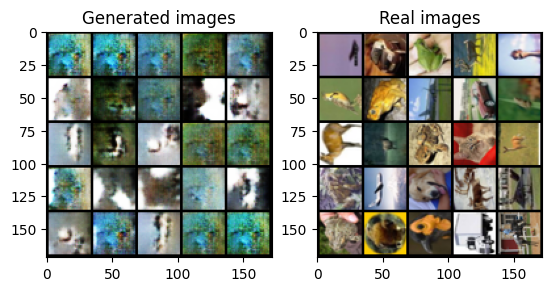

In [9]:
Ims = generator(torch.randn(25,100,device=device))*0.5+0.5
grid_im = torchvision.utils.make_grid(Ims, nrow=5).transpose(0,2).cpu()
plt.subplot(1,2,1)
plt.imshow(grid_im)
plt.title('Generated images')
train_loader = DataLoader(data,batch_size=25,shuffle=True)
ims,_ = next(iter(train_loader))
grid_im = torchvision.utils.make_grid(ims, nrow=5).transpose(0,2)
plt.subplot(1,2,2)
plt.imshow(grid_im)
plt.title('Real images')
plt.show()

## Conditional GANs

Nice, those look pretty good. But what if we wanted to condition our generation based on a class label or some other information. Easy. We'll just augment the latent space and discriminator input with the extra input. Let's train a conditional GAN.

In [10]:
# Lets start by building a conditional discriminator - this will try to tell if our image is real or fake, conditioned on a class
class ConditionalDiscriminator(nn.Module):
    
    def __init__(self,channels=3,num_classes=10):
        super().__init__()
        
        self.encoder = nn.Sequential(nn.Conv2d(channels,32,kernel_size=4,stride=2,padding=1,bias=False),
                                     nn.BatchNorm2d(32),
                                     nn.LeakyReLU(0.2,inplace=True),
                                     nn.Conv2d(32,64,kernel_size=4,stride=2,padding=1,bias=False),
                                     nn.BatchNorm2d(64),
                                     nn.LeakyReLU(0.2,inplace=True),
                                     nn.Conv2d(64,128,kernel_size=4,stride=2,padding=1,bias=False),
                                     nn.BatchNorm2d(128),
                                     nn.LeakyReLU(0.2,inplace=True),
                                     nn.Flatten())

        self.classifier  = nn.Sequential(nn.Linear(2048 + num_classes,1,bias=False),
                                     nn.Sigmoid())
        self.num_classes = num_classes
        
    def forward(self,x,labels):
        
        x_in = torch.hstack((self.encoder(x), torch.nn.functional.one_hot(labels,self.num_classes)))
        
        return self.classifier(x_in)

In [11]:
# Next we will build a generator, this will take random noise in and generate an image
class ConditionalGenerator(nn.Module):
    
    def __init__(self,num_classes=10):
        super().__init__()
        
        self.num_classes = num_classes
        
        self.decoder = nn.Sequential(nn.Unflatten(dim=-1,unflattened_size=(-1,1,1)),
                                     nn.ConvTranspose2d(100,256,kernel_size=4,stride=2,padding=1),
                                     nn.LeakyReLU(),
                                     nn.ConvTranspose2d(256,128,kernel_size=4,stride=2,padding=1),
                                     nn.LeakyReLU(),
                                     nn.ConvTranspose2d(128,64,kernel_size=4,stride=2,padding=1),
                                     nn.LeakyReLU(),
                                     nn.ConvTranspose2d(64,32,kernel_size=4,stride=2,padding=1),
                                     nn.LeakyReLU(),
                                     nn.ConvTranspose2d(32,3,kernel_size=4,stride=2,padding=1),
                                     nn.Tanh())
        
    def forward(self,x,labels):
        
        x_in = torch.hstack((x, torch.nn.functional.one_hot(labels,self.num_classes)))
        
        return self.decoder(x_in)

In [12]:
generator = ConditionalGenerator(num_classes=10).to(device)
discriminator = ConditionalDiscriminator(num_classes=10).to(device)

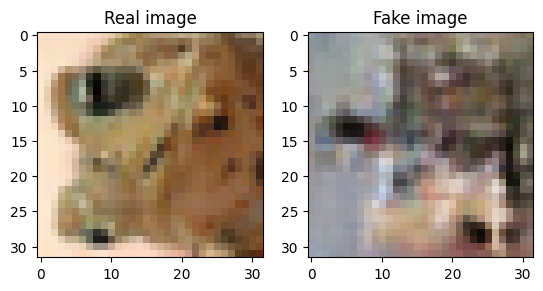

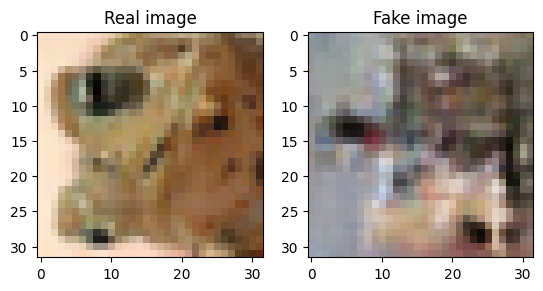

In [13]:
avg_g_loss = None  # exponential moving average
avg_d_loss = None  # exponential moving average
n_epochs = 100

optim_1 = torch.optim.Adam(generator.parameters(),lr=2e-5, betas=(0.5, 0.999))
optim_2 = torch.optim.Adam(discriminator.parameters(),lr=2e-5, betas=(0.5, 0.999)) # Note different learning rates - I don't want my discriminator collapsing first

# This is only going to work if I can manage to find an equilibrium between the losses
    
disc_loss = nn.BCELoss()

for step in range(n_epochs):

    t = tqdm(total=len(train_loader))

    for i,batch in enumerate(train_loader):
        im,labels = batch
        
        im = im.to(device)*2-1
        labels=labels.to(device)
        
        ims_fake = generator(torch.randn(im.shape[0],90,device=device),labels)
        
        # Make some noisy labels - see GAN hacks, ideally this would be just ones and zeros
        real_labels = torch.ones((im.shape[0],1),device=device) - 0.2*torch.rand((im.shape[0],1),device=device)
        fake_labels = torch.zeros((im.shape[0],1),device=device) + 0.2*torch.rand((im.shape[0],1),device=device)
            
        # Generator step
        optim_1.zero_grad()
        fake_pred = discriminator(ims_fake,labels) 
        loss = disc_loss(fake_pred,real_labels) 
        loss.backward() 
        optim_1.step()

    
        
        if avg_g_loss is None:
            avg_g_loss = loss.item()
        else:
            avg_g_loss = 0.95*avg_g_loss + 0.05*loss.item()
        
        #Discriminator  step
        optim_2.zero_grad()
        fake_pred = discriminator(ims_fake.detach(),labels) # Note that we detach the image to prevent gradient flow here 
        real_pred = discriminator(im,labels)
        
        real_loss = disc_loss(real_pred,real_labels)
        fake_loss = disc_loss(fake_pred,fake_labels)
        
        loss = (real_loss + fake_loss)/2.0
        loss.backward()    
        optim_2.step()

        if avg_d_loss is None:
            avg_d_loss = loss.item()
        else:
            avg_d_loss = 0.95*avg_d_loss + 0.05*loss.item()            
    
        # Some visualisation during training.
        t.update(1)
        t.set_description(f"Iter: {step}. Average Generator Loss: {avg_g_loss:.04f} Average Discriminator Loss: {avg_d_loss:.04f}")
    t.reset()
        
    plt.clf()
    plt.subplot(1,2,1)
    plt.imshow(0.5*im[0,:,:,:].transpose(0,2).cpu()+0.5)
    plt.title('Real image')
    plt.subplot(1,2,2)
    plt.imshow(0.5*ims_fake[0,:,:,:].transpose(0,2).detach().cpu()+0.5)
    plt.title('Fake image')
    display.clear_output(wait=True)
    display.display(plt.gcf())

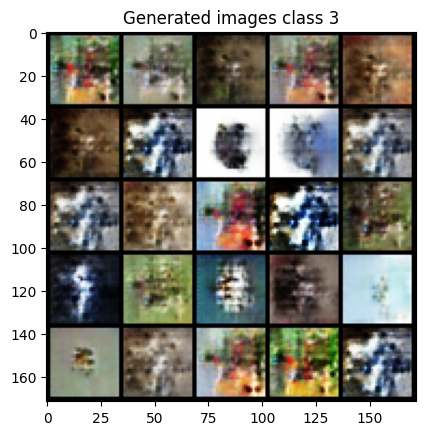

In [14]:
class_label = 3
Ims = generator(torch.randn(25,90,device=device),class_label*torch.ones((25,),device=device).long())*0.5+0.5
grid_im = torchvision.utils.make_grid(Ims, nrow=5).transpose(0,2).cpu()
plt.imshow(grid_im)
plt.title('Generated images class %d'%class_label)
plt.show()

These are meant to be cats...